In [1]:
import pandas as pd
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb

In [ ]:
# !gsutil cp /home/eanegrin/buckets/b1/datasets/competencia_02_fe_v01.parquet /home/eanegrin/datasets/

In [2]:
# base_path = '/content/drive/MyDrive/DMEyF/2024/'
base_path = 'C:/Eugenio/Maestria/DMEyF/'
# base_path = '/home/eanegrin/buckets/b1/'

dataset_path = base_path + 'datasets/'
modelos_path = base_path + 'modelos/'
db_path = base_path + 'db/'
dataset_file = 'competencia_02_fe_v01.parquet' # CAMBIAR EN LA VM

ganancia_acierto = 273000
costo_estimulo = 7000

# agregue sus semillas
semillas = [122219, 109279, 400391, 401537, 999961]

### Cargo el dataset y creo columnas necesarias

In [3]:
# cargo solo el mes que necesito

# data = pd.read_parquet('/home/eanegrin/datasets/' + dataset_file)
data = pl.scan_parquet(dataset_path + dataset_file).filter(pl.col("foto_mes") == 202106).collect()

In [4]:
# convirto a pandas dataframe
data = data.to_pandas()

In [5]:
# Asignamos pesos a las clases

data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

In [6]:
data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

In [7]:
X_train = data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_train_binaria1 = data['clase_binaria1'] # Solo BAJA+2
y_train_binaria2 = data['clase_binaria2'] # junta a los 2 BAJA
w_train = data['clase_peso']

### Cargo el modelo pre-entrenado y calculo el punto de corte optimo

In [8]:
model = lgb.Booster(model_file=modelos_path + 'lgb_competencia2_v001.txt')

In [9]:
y_pred_lgm = model.predict(X_train)

In [10]:
ganancia = np.where(y_train_binaria1 == 1, ganancia_acierto, 0) - np.where(y_train_binaria1 == 0, costo_estimulo, 0) # uso la binaria 1 porque es la que solo considera a los BAJA+2

idx = np.argsort(y_pred_lgm)[::-1]

ganancia = ganancia[idx]
y_pred_lgm = y_pred_lgm[idx]

ganancia_cum = np.cumsum(ganancia)

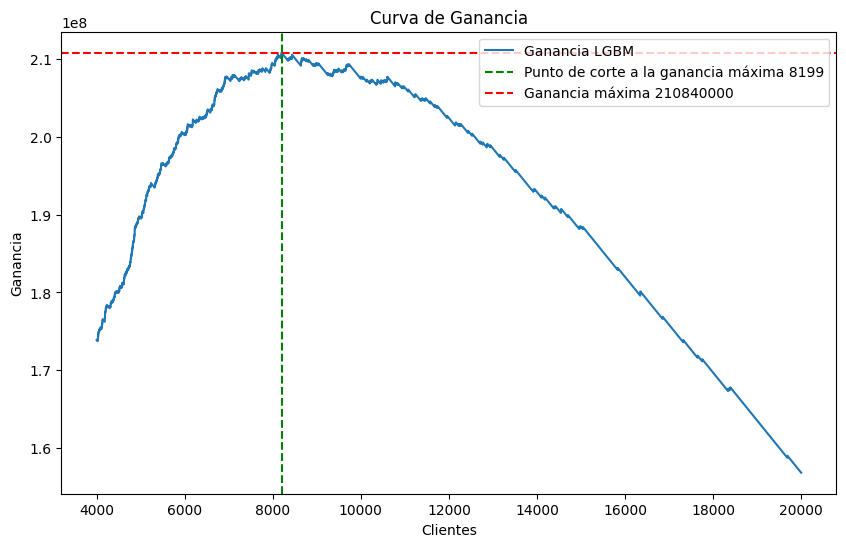

In [11]:
piso_envios = 4000
techo_envios = 20000

ganancia_max = ganancia_cum.max()
gan_max_idx = np.where(ganancia_cum == ganancia_max)[0][0]

plt.figure(figsize=(10, 6))
plt.plot(range(piso_envios, len(ganancia_cum[piso_envios:techo_envios]) + piso_envios), ganancia_cum[piso_envios:techo_envios], label='Ganancia LGBM')
plt.axvline(x=gan_max_idx, color='g', linestyle='--', label=f'Punto de corte a la ganancia máxima {gan_max_idx}')
plt.axhline(y=ganancia_max, color='r', linestyle='--', label=f'Ganancia máxima {ganancia_max}')
plt.title('Curva de Ganancia')
plt.xlabel('Clientes')
plt.ylabel('Ganancia')
plt.legend()
plt.show()